In [1]:
import pickle
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from modt.modt import MoDT
from modt._initialization import *
from modt.visualization import *
from modt.utility import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 12

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR

In [3]:
#data_input = pickle.load(open("../datasets/generated7_input.np", "rb"))
#data_target = pickle.load(open("../datasets/generated7_target.np", "rb"))
data_input = pickle.load(open("../datasets/steel_input.pd", "rb"))
data_target = pickle.load(open("../datasets/steel_target.pd", "rb"))
parameters = {
    "X": data_input,
    "y": data_target,
    "n_experts": 99,
    "iterations": 100,
    "max_depth": 1,
    "init_learning_rate": 100,
    "learning_rate_decay": 0.995,
    "initialization_method": "random",
    "use_2_dim_gate_based_on": None,
    "save_likelihood": False,
    }

parameters_fit = {
    "optimization_method": "least_squares_linear_regression",
    "early_stopping": False,
    }

modt = MoDT(**parameters)
#modt.fit(**parameters_fit)

## Estimate n experts using BIC

In [4]:
bic = modt.estimate_n_experts(range(1, 9), return_array=True)
#plt.plot(range(1, 9), bic)

C:\Users\Robert\Anaconda3\envs\MA1\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Duration: 0.5942989000000125
N_expert tested: range(1, 9)
BIC: [ -17836.55  -72318.45  -92641.77  -97584.24  -96893.95 -115245.45
 -108057.18 -109644.15]
BIC %:  [0.03 0.1  0.13 0.14 0.14 0.16 0.15 0.15]
Max BIC for expert: 6


## Estimate n experts by (simple) testing

In [5]:
repeats = 5
outer_accuracies = []
for n_experts in range(1,9):
    inner_accuracies = []
    for _ in range(repeats):
        parameters["n_experts"] = n_experts
        modt = MoDT(**parameters)
        modt.fit(**parameters_fit)
        inner_accuracies.append(modt.score_internal_disjoint())
        #print(modt.n_experts)
    outer_accuracies.append(np.mean(inner_accuracies))
#plt.plot(range(1, 9), outer_accuracies)    

<Figure size 432x288 with 0 Axes>

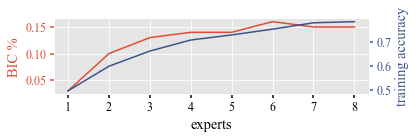

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig = plt.gcf()

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()

p1, = host.plot(range(1, 9), bic, color="#E24A33", label="BIC")
host.grid(b=None, zorder=1)
p2, = par1.plot(range(1, 9), outer_accuracies, color="#3b528b", label="acc.")

host.set_xlabel("experts")
host.set_ylabel("BIC %")
par1.set_ylabel("training accuracy")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)

host.tick_params(axis='x', **tkw)

lines = [p1, p2]

#host.legend(lines, [l.get_label() for l in lines])


fig.set_size_inches(7, 1.4)
plt.grid(b=None)



plt.savefig("output/bic-accuracy-d1-full.pdf", bbox_inches="tight", dpi=300)

plt.show()

In [25]:
N_EXPERTS = 6
parameters["n_experts"] = N_EXPERTS

modt = MoDT(**parameters)
modt.fit(**parameters_fit)

Min:  0.5373518804739825 Max:  0.75682637815559
Accuracy disjoint DTs: 0.75682637815559


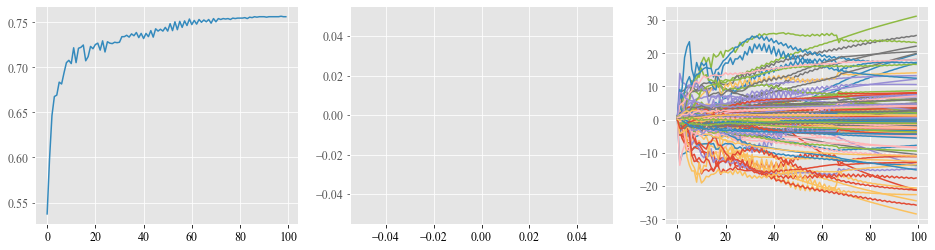

In [26]:
fig = plt.gcf()
fig.set_size_inches(16, 4)
plot_training(modt)
print("Accuracy disjoint DTs:", modt.score_internal_disjoint())

## Use Optuna to find optimized hyperparamters
Might take some time, test for one iteration first

In [10]:
df_hyperparameters = optuna_optimization(data_input,data_target,n_experts=N_EXPERTS,max_depth=parameters["max_depth"],gating_2D=False,runs=50,only_random=True)
df_best = df_hyperparameters.sort_values(by=["user_attrs_accuracy_val"], ascending=False).head(1)
print("Best run. Training acc.: {} Test acc.: {}".format(round(df_best.user_attrs_accuracy_train.values[0],4),round(df_best.user_attrs_accuracy_val.values[0],4)))

[I 2021-08-11 19:36:25,207] A new study created in RDB with name: 2021.08.11 19:36:25 Hyper: Adhoc str


Duration: 264.42189570000005 Returning trials...
Best run. Training acc.: 0.7716 Test acc.: 0.711


In [12]:
parameters["init_learning_rate"] = df_best.params_init_learning_rate.values[0]
parameters["learning_rate_decay"] = df_best.params_learning_rate_decay.values[0]
parameters["use_2_dim_gate_based_on"] = df_best.params_use_2_dim_gate_based_on.values[0]
parameters_fit["optimization_method"] = df_best.params_optimization_method.values[0]
parameters_fit["use_2_dim_gate_based_on"] = df_best.params_use_2_dim_gate_based_on.values[0]                                     

if df_best.params_use_2_dim_gate_based_on.values[0] == "str":
    parameters["initialization_method"] = "random"
elif df_best.params_use_2_dim_gate_based_on.values[0] == "Kmeans_init":
    parameters["initialization_method"] = Kmeans_init()
elif df_best.params_use_2_dim_gate_based_on.values[0] == "KDTmeans_init":
    alpha = df_best["params_alpha"].values[0]
    beta = df_best["params_beta"].values[0]
    gamma = df_best["params_gamma"].values[0]
    parameters["initialization_method"] = KDTmeans_init(alpha=alpha, beta=beta, gamma=gamma)
elif df_best.params_use_2_dim_gate_based_on.values[0] == "BGM_init":
    mean_precision_prior = df_best["mean_precision_prior"].values[0]      
    weight_concentration_prior_type = df_best["params_weight_concentration_prior_type"].values[0]      
    weight_concentration_prior = df_best["params_weight_concentration_prior"].values[0]      
    weight_cutoff = df_best["params_weight_cutoff"].values[0]      
    parameters["initialization_method"] = BGM_init(mean_precision_prior=mean_precision_prior,
                                                    weight_concentration_prior_type=weight_concentration_prior_type,
                                                    weight_concentration_prior=weight_concentration_prior,
                                                    weight_cutoff=weight_cutoff)
print(parameters_fit)
print(list(parameters.items())[2:])

{'optimization_method': 'ridge_regression', 'early_stopping': False, 'use_2_dim_gate_based_on': None}
[('n_experts', 6), ('iterations', 100), ('max_depth', 1), ('init_learning_rate', 99.4497417475346), ('learning_rate_decay', 0.9943213429675807), ('initialization_method', 'random'), ('use_2_dim_gate_based_on', None), ('save_likelihood', False)]


## Are the hyperparameters really better?
(Measuring training accuracy)

Min:  0.5311695002575991 Max:  0.7686759402369913
Accuracy disjoint DTs: 0.7686759402369913


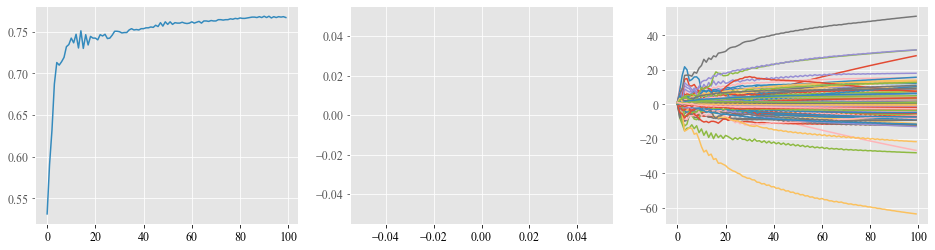

In [34]:
modt = MoDT(**parameters)
modt.fit(**parameters_fit)
#parameters["use_2_dim_gate_based_on"] = "feature_importance_lr"
fig = plt.gcf()
fig.set_size_inches(16, 4)
plot_training(modt)
print("Accuracy disjoint DTs:", modt.score_internal_disjoint())

ValueError: X must have 2 dimensions for visualization. Use 2D gate if dataset has more dimensions.

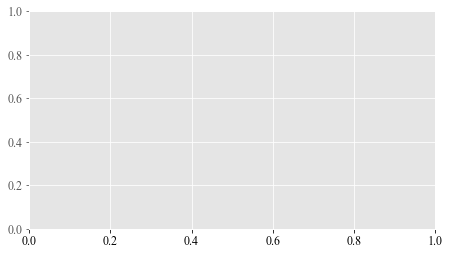

In [35]:
fig = plt.gcf()
fig.set_size_inches(16, 4)
plt.subplot(1, 2, 1)
plot_gating(modt,iteration=modt.best_iteration,title=False,axis_digits=True,inverse_transform_standardization=True,jitter=False)
plt.subplot(1, 2, 2)
plot_gating(modt,iteration=modt.best_iteration,title=False,axis_digits=True,inverse_transform_standardization=True,jitter=True,legend=True)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(14, 6)
fig.set_size_inches(5, 2.5)
plot_gating(modt,iteration=modt.best_iteration,title=False,axis_digits=True,rasterize=True,inverse_transform_standardization=True,point_size=6,jitter=True,legend=True)
plt.savefig("output/cs_steel_d1_gate.pdf", bbox_inches="tight", dpi=300)

## Plot DTs

In [37]:
modt.train_disjoint_trees(modt.best_iteration, tree_algorithm="sklearn_asymmetric")

In [38]:
#plot_dt_dtreeviz(modt,0,colors="visible", asymmetric=True)
#plot_dt_dtreeviz(modt,1,colors="visible", asymmetric=True)
#plot_dt_dtreeviz(modt,2,colors="visible", asymmetric=True)
#plot_dt_dtreeviz(modt,3,colors="visible", asymmetric=True)
#plot_dt_dtreeviz(modt,4,colors="visible", asymmetric=True)
#plot_dt_dtreeviz(modt,5,colors="visible", asymmetric=True)

In [41]:
plot_dt_dtreeviz(modt,0,colors="visible", asymmetric=True, fancy=False)


In [42]:
plot_dt_dtreeviz(modt,1,colors="visible", asymmetric=True, fancy=False)


In [43]:
plot_dt_dtreeviz(modt,2,colors="visible", asymmetric=True, fancy=False)


In [44]:
plot_dt_dtreeviz(modt,3,colors="visible", asymmetric=True, fancy=False)


In [45]:
plot_dt_dtreeviz(modt,4,colors="visible", asymmetric=True, fancy=False)


In [46]:
plot_dt_dtreeviz(modt,5,colors="visible", asymmetric=True, fancy=False)

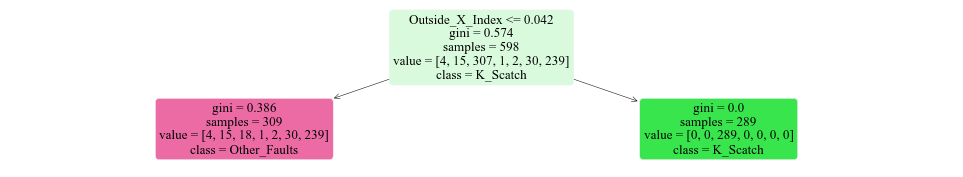

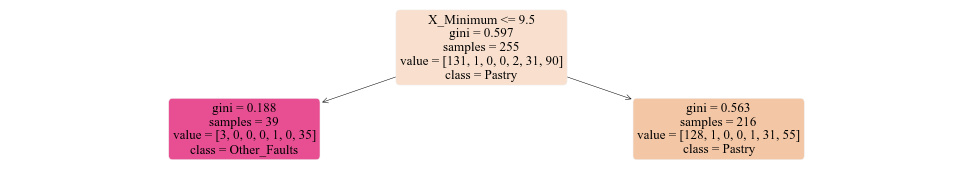

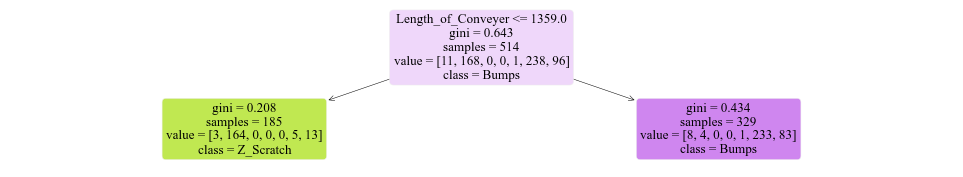

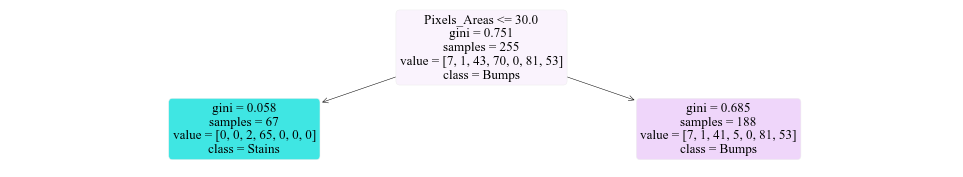

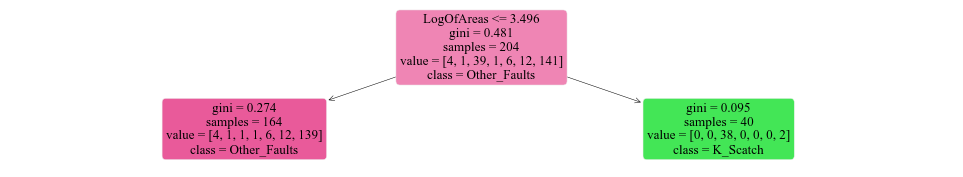

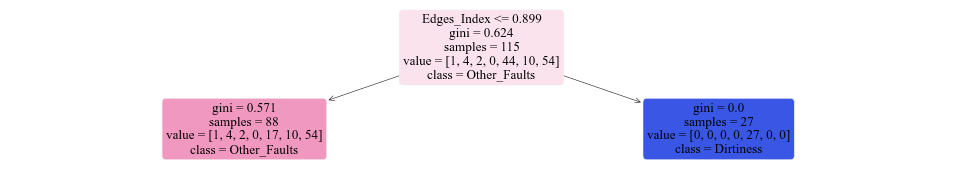

In [36]:
for expert in range(0,modt.n_experts):
    plot_disjoint_dt(modt,expert=expert,size=(17,3))

In [ ]:
#modt.train_disjoint_trees(modt.best_iteration, tree_algorithm="optimal_trees")

In [ ]:
#modt.DT_experts_alternative_algorithm[0].get_learner()

In [ ]:
#modt.DT_experts_alternative_algorithm[1].get_learner()

In [ ]:
#modt.DT_experts_alternative_algorithm[2].get_learner()

In [ ]:
#modt.DT_experts_alternative_algorithm[3].get_learner()